In [10]:
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_datareader
import datetime
import pandas_datareader.data as web
from scipy.stats import norm

dfticker = pd.read_csv("D:\\stocks\\QUALGRWOTH.csv", index_col = False)
tickers = []
length = len(dfticker)
for i in range(0,length):
    tickers.append(dfticker['Ticker'][i]+".NS")

In [11]:
data = pd.DataFrame()

for t in tickers:
    data[t] = web.DataReader(t, data_source='yahoo', start='2016-1-1')['Adj Close']
     

        
data.to_csv("QUALITYVOLSTOCKSJUly2022.csv")

In [12]:
returns = np.log(data / data.shift(1))
vols = returns.std() * 252 ** 0.5 *100
vols

ASTRAZEN.NS      36.743438
RELAXO.NS        30.455822
PIDILITIND.NS    26.163086
TATAELXSI.NS     39.092119
PAGEIND.NS       33.989080
                   ...    
GLOBUSSPR.NS     55.374304
DWARKESH.NS      60.494960
VINYLINDIA.NS    49.987927
DCMSHRIRAM.NS    50.208676
SPLPETRO.NS      39.729691
Length: 112, dtype: float64

In [14]:
annual_returns = returns.mean() * 252 * 100
annual_returns

ASTRAZEN.NS      13.457230
RELAXO.NS        21.560367
PIDILITIND.NS    22.491158
TATAELXSI.NS     31.824834
PAGEIND.NS       19.146914
                   ...    
GLOBUSSPR.NS     39.499205
DWARKESH.NS      42.596675
VINYLINDIA.NS    25.975806
DCMSHRIRAM.NS    32.385292
SPLPETRO.NS      35.313618
Length: 112, dtype: float64

In [15]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import pandas_datareader.data as web
import datetime
import math

class ValueAtRiskMonteCarlo:
    
    def __init__(self, S, mu, sigma, c, n, iterations):
        self.S = S
        self.mu = mu
        self.sigma = sigma
        self.c = c
        self.n = n
        self.iterations = iterations 

    def simulation(self):
        stock_data = np.zeros([self.iterations, 1])	
        rand = np.random.normal(0, 1, [1, self.iterations])

        #equation for the S(t) stock price
        stock_price = self.S*np.exp(self.n*(self.mu - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.n)*rand)
        #we have to sort the stock prices to determine the percentile
        stock_price = np.sort(stock_price)

        #it depends on the confidence level: 95% -> 5 and 99% -> 1
        percentile = np.percentile(stock_price,(1-self.c)*100)

        return self.S-percentile

In [16]:

df = pd.DataFrame(columns = ['Ticker', 'Cov_mar','Market_var','Beta','Volatility%','Return%','CV','Sharp Ratio','CAGR','MAXDD%','Value at Risk']) 
data = pd.DataFrame()
data['^BSESN'] = web.DataReader('^BSESN', data_source='yahoo', start='2015-1-1')['Adj Close'] 

for t in tickers:
    try:
        data[t] = web.DataReader(t, data_source='yahoo', start='2015-1-1')['Adj Close']  
    except:
        continue
    sec_returns = np.log( data / data.shift(1) )
    cov = sec_returns.cov()*252
    cov_with_market = cov[t][0]
 
      
    dr = data[t].pct_change()
    dcum = (1 + dr).cumprod()
    n = len(data)/252
    CAGR = ((dcum[-1])**(1/n) - 1)*100
      
 
    
    droll = dcum.cummax()
    ddw = droll - dcum
    ddmax = ddw/droll
    max_dd = (ddmax.max())*100
   
 

    market_var = sec_returns['^BSESN'].var() * 252

    returns = np.log(data[t] / data[t].shift(1))
    MSFT_beta = cov_with_market / market_var
    MSFT_er = returns.mean()*252
    Sharp = (MSFT_er - 0.05) / (sec_returns[t].std() * 252 ** 0.5)
   

    #returns = np.log(data[t] / data[t].shift(1))
    vols = returns.std() * 252 ** 0.5 *100
    annual_returns = returns.mean() * 252 * 100
    CV = (vols/annual_returns)*100
    S = 100000    #this is the investment (stocks or whatever)
    c=0.95   #condifence level: this time it is 99%
    n = 730   #1 day 
    iterations = 100000 #number of paths in the Monte-Carlo simulation
    mu = np.mean(returns)
    sigma = np.mean(returns.std())

    model = ValueAtRiskMonteCarlo(S,mu,sigma,c,n,iterations)
    val = model.simulation()

 
    
 
    df = df.append(pd.Series([t,cov_with_market,market_var,MSFT_beta,vols,annual_returns,CV,Sharp,CAGR,max_dd,val], index=df.columns ), ignore_index=True)
                                    
                        
  

In [17]:
df1 = df[(df['CAGR']>10 ) & (df['Return%']>10)]
df2 = df1.sort_values(by='Return%', ascending=False)
df2

,Ticker,Cov_mar,Market_var,Beta,Volatility%,Return%,CV,Sharp Ratio,CAGR,MAXDD%,Value at Risk
61,TANLA.NS,0.024976,0.032642,0.765161,55.545642,55.962498,99.255116,0.917489,74.948706,56.960476,31028.319860
108,DWARKESH.NS,0.030232,0.032642,0.926162,60.771198,53.489306,113.613735,0.797899,70.677238,81.725889,49531.627333
40,KIOCL.NS,0.025442,0.032642,0.779418,56.968943,53.256928,106.970013,0.847074,48.871961,90.200921,41193.985371
74,BALAMINES.NS,0.038494,0.032642,1.179302,53.875354,51.413799,104.787732,0.861503,67.173203,70.464059,34742.402337
29,SAREGAMA.NS,0.028540,0.032642,0.874349,54.415815,50.967450,106.765819,0.844744,66.429090,77.013541,37238.805879
...,...,...,...,...,...,...,...,...,...,...,...
63,ALKEM.NS,0.008251,0.032642,0.252761,26.874126,13.883004,193.575727,0.330541,12.843237,27.406849,36332.366763
82,AVTNPL.NS,0.032551,0.032642,0.997206,47.956808,13.503462,355.144533,0.177315,14.449292,67.578919,72156.651505
45,KSB.NS,0.024340,0.032642,0.745664,34.206714,12.646194,270.490180,0.223529,13.472874,56.078526,53301.516090
75,EXPLEOSOL.NS,0.018471,0.032642,0.565883,39.307940,11.942703,329.137712,0.176623,12.677831,78.165915,62370.233182


In [18]:
df2.to_csv("QUALITYGROWTHJULY2022.csv")

Text(0, 0.5, 'Expected Return')

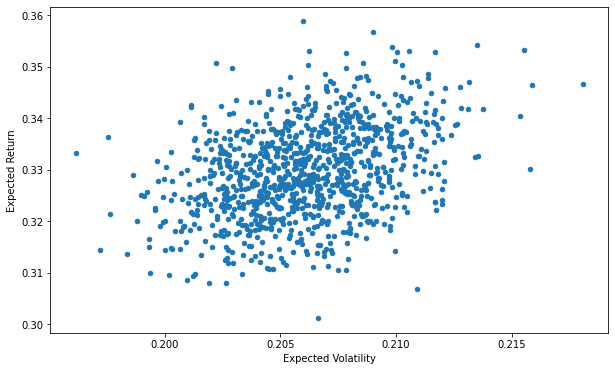

In [19]:
pf_data = pd.DataFrame()
for t in df1["Ticker"]:
    pf_data[t] = web.DataReader(t, data_source = 'yahoo', start = '2019-1-1')['Adj Close']

log_returns = np.log(pf_data / pf_data.shift(1))
num_assets = len(df1["Ticker"])
num_assets
weights = np.random.random(num_assets)
weights /= np.sum(weights)
np.sum(weights * log_returns.mean()) * 252
np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * 252, weights)))
pfolio_returns = []
pfolio_volatilities = []
wts = []
for x in range (1000):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    pfolio_returns.append(np.sum(weights * log_returns.mean()) * 252)
    pfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * 252, weights))))
    wts.append(weights)
pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)
wts= np.array(wts)
#pfolio_returns, pfolio_volatilities
portfolios = pd.DataFrame({'Return': pfolio_returns, 'Volatility': pfolio_volatilities})
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10, 6));
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

In [20]:
df = pd.DataFrame(data=wts)
df.columns = df1["Ticker"]
df_col_merged = pd.concat([portfolios, df], axis=1)
dft = df_col_merged.loc[df_col_merged['Return'].argmax()]
dft*100

Return           35.883248
Volatility       20.595799
ASTRAZEN.NS       0.050119
RELAXO.NS         1.313323
PIDILITIND.NS     1.543316
                   ...    
GLOBUSSPR.NS      0.854853
DWARKESH.NS       1.765588
VINYLINDIA.NS     0.461515
DCMSHRIRAM.NS     0.136457
SPLPETRO.NS       0.373551
Name: 503, Length: 110, dtype: float64

In [21]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import pandas_datareader.data as web
import datetime
import math

class ValueAtRiskMonteCarlo:
    
    def __init__(self, S, mu, sigma, c, n, iterations):
        self.S = S
        self.mu = mu
        self.sigma = sigma
        self.c = c
        self.n = n
        self.iterations = iterations 

    def simulation(self):
        stock_data = np.zeros([self.iterations, 1])	
        rand = np.random.normal(0, 1, [1, self.iterations])

        #equation for the S(t) stock price
        stock_price = self.S*np.exp(self.n*(self.mu - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.n)*rand)
        #we have to sort the stock prices to determine the percentile
        stock_price = np.sort(stock_price)

        #it depends on the confidence level: 95% -> 5 and 99% -> 1
        percentile = np.percentile(stock_price,(1-self.c)*100)

        return self.S-percentile

if __name__ == "__main__":
    S = 100000    #this is the investment (stocks or whatever)
    c=0.95   #condifence level: this time it is 99%
    n = 730   #1 day 
    iterations = 100000 #number of paths in the Monte-Carlo simulation

    #historical data to approximate mean and standard deviation
    d = {}

    #download stock related data from Yahoo Finance
    for t in df1["Ticker"]:
        citi = web.DataReader(t,data_source='yahoo',start='2017-1-1')
           #we can use pct_change() to calculate daily returns
        citi['returns'] = citi['Adj Close'].pct_change()

    #we can assume daily returns to be normally sidtributed: mean and variance (standard deviation)
    #can describe the process
        mu = np.mean(citi['returns'])
        sigma = np.std(citi['returns'])

        model = ValueAtRiskMonteCarlo(S,mu,sigma,c,n,iterations)
        val = model.simulation()
        d[t] = val
        print("VALUE AT RSIK for {} is".format(t))
        print('Value at risk with Monte-Carlo simulation in INR: %0.2f' % val)
    print("The minimum value at risk for the portofolios are:")
    print(min(d.values()))

VALUE AT RSIK for ASTRAZEN.NS is
Value at risk with Monte-Carlo simulation in INR: 37556.05
VALUE AT RSIK for RELAXO.NS is
Value at risk with Monte-Carlo simulation in INR: -3423.38
VALUE AT RSIK for PIDILITIND.NS is
Value at risk with Monte-Carlo simulation in INR: 2380.17
VALUE AT RSIK for TATAELXSI.NS is
Value at risk with Monte-Carlo simulation in INR: -25014.30
VALUE AT RSIK for PAGEIND.NS is
Value at risk with Monte-Carlo simulation in INR: 27506.59
VALUE AT RSIK for ASIANPAINT.NS is
Value at risk with Monte-Carlo simulation in INR: 9112.83
VALUE AT RSIK for NESTLEIND.NS is
Value at risk with Monte-Carlo simulation in INR: 2452.70
VALUE AT RSIK for HATSUN.NS is
Value at risk with Monte-Carlo simulation in INR: 30086.68
VALUE AT RSIK for NAVINFLUOR.NS is
Value at risk with Monte-Carlo simulation in INR: -3454.05
VALUE AT RSIK for JUBLFOOD.NS is
Value at risk with Monte-Carlo simulation in INR: 1860.99
VALUE AT RSIK for BERGEPAINT.NS is
Value at risk with Monte-Carlo simulation in 

VALUE AT RSIK for SONATSOFTW.NS is
Value at risk with Monte-Carlo simulation in INR: 27507.62
VALUE AT RSIK for IGL.NS is
Value at risk with Monte-Carlo simulation in INR: 40129.19
VALUE AT RSIK for KOPRAN.NS is
Value at risk with Monte-Carlo simulation in INR: 54081.62
VALUE AT RSIK for LUXIND.NS is
Value at risk with Monte-Carlo simulation in INR: 43600.18
VALUE AT RSIK for CYBERTECH.NS is
Value at risk with Monte-Carlo simulation in INR: 75743.22
VALUE AT RSIK for DSSL.NS is
Value at risk with Monte-Carlo simulation in INR: 23944.90
VALUE AT RSIK for GULPOLY.NS is
Value at risk with Monte-Carlo simulation in INR: 46805.64
VALUE AT RSIK for GRAVITA.NS is
Value at risk with Monte-Carlo simulation in INR: 36574.57
VALUE AT RSIK for TALBROAUTO.NS is
Value at risk with Monte-Carlo simulation in INR: 47335.35
VALUE AT RSIK for TRIVENI.NS is
Value at risk with Monte-Carlo simulation in INR: 52777.08
VALUE AT RSIK for KNRCON.NS is
Value at risk with Monte-Carlo simulation in INR: 39277.80
V

ConnectionError: HTTPSConnectionPool(host='finance.yahoo.com', port=443): Read timed out.

In [22]:
for key,value in d.items():
    print(" The Value at risk per 1L invested in stock {} is {:0.2f}".format(key,value))

 The Value at risk per 1L invested in stock ASTRAZEN.NS is 37556.05
 The Value at risk per 1L invested in stock RELAXO.NS is -3423.38
 The Value at risk per 1L invested in stock PIDILITIND.NS is 2380.17
 The Value at risk per 1L invested in stock TATAELXSI.NS is -25014.30
 The Value at risk per 1L invested in stock PAGEIND.NS is 27506.59
 The Value at risk per 1L invested in stock ASIANPAINT.NS is 9112.83
 The Value at risk per 1L invested in stock NESTLEIND.NS is 2452.70
 The Value at risk per 1L invested in stock HATSUN.NS is 30086.68
 The Value at risk per 1L invested in stock NAVINFLUOR.NS is -3454.05
 The Value at risk per 1L invested in stock JUBLFOOD.NS is 1860.99
 The Value at risk per 1L invested in stock BERGEPAINT.NS is 21000.21
 The Value at risk per 1L invested in stock NELCO.NS is 32734.64
 The Value at risk per 1L invested in stock HINDUNILVR.NS is 3301.23
 The Value at risk per 1L invested in stock VINATIORGA.NS is 658.34
 The Value at risk per 1L invested in stock ESAB

In [23]:
df2.reset_index(inplace = True)

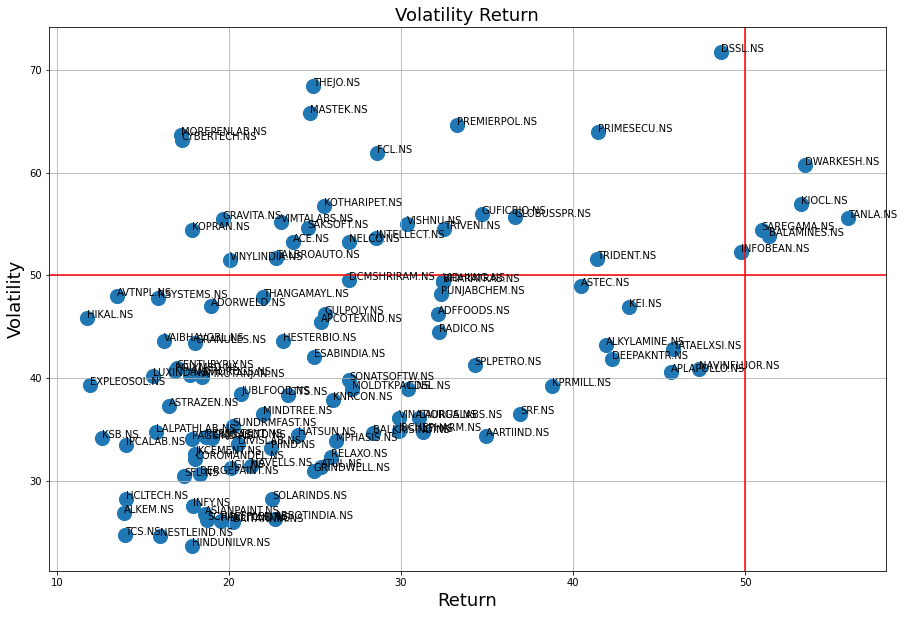

In [24]:

plt.figure(figsize=[15,10])
x= df2['Return%']
y = df2['Volatility%']
annotations = np.array(df2["Ticker"])
plt.grid(True)
plt.title('Volatility Return', fontsize=18, color='black')
plt.xlabel("Return",fontsize=18, color='black')
plt.ylabel("Volatility", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
i=0
for labels in annotations:
    plt.annotate(labels, (x[i], y[i]))
    i=i+1
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50, color='r', linestyle='-')
plt.show()


In [25]:
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Read in price data
df = data

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('^BSESN', 0.0), ('ASTRAZEN.NS', 0.0), ('RELAXO.NS', 0.0), ('PIDILITIND.NS', 0.0), ('TATAELXSI.NS', 0.05102), ('PAGEIND.NS', 0.0), ('ASIANPAINT.NS', 0.0), ('NESTLEIND.NS', 0.0), ('HATSUN.NS', 0.01371), ('NAVINFLUOR.NS', 0.11837), ('JUBLFOOD.NS', 0.0), ('BERGEPAINT.NS', 0.0), ('NELCO.NS', 0.0), ('HINDUNILVR.NS', 0.0194), ('VINATIORGA.NS', 0.00277), ('ESABINDIA.NS', 0.0), ('GRINDWELL.NS', 0.00521), ('ALKYLAMINE.NS', 0.03548), ('SFL.NS', 0.0), ('HAVELLS.NS', 0.0), ('BRITANNIA.NS', 0.0), ('SCHAEFFLER.NS', 0.0), ('SOLARINDS.NS', 0.0), ('CRISIL.NS', 0.0), ('PIIND.NS', 0.0), ('LALPATHLAB.NS', 0.0), ('RADICO.NS', 0.0), ('ABBOTINDIA.NS', 0.06925), ('POLYMED.NS', 0.0), ('HESTERBIO.NS', 0.0), ('SAREGAMA.NS', 0.05335), ('ASTEC.NS', 0.02564), ('FCL.NS', 0.0), ('ATUL.NS', 0.0), ('MOLDTKPAC.NS', 0.0), ('CDSL.NS', 0.0), ('DIVISLAB.NS', 0.0), ('SUNDRMFAST.NS', 0.0), ('SRF.NS', 0.0), ('PERSISTENT.NS', 0.0), ('APLAPOLLO.NS', 0.09143), ('KIOCL.NS', 0.05386), ('VIDHIING.NS', 0.0), ('INFOBEAN.N

(0.5314052298976736, 0.20614482008011809, 2.480805628290423)

In [26]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=700000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: INR{:.2f}".format(leftover))

Discrete allocation: {'NAVINFLUOR.NS': 21, 'APLAPOLLO.NS': 73, 'TANLA.NS': 57, 'ABBOTINDIA.NS': 3, 'INFOBEAN.NS': 66, 'KIOCL.NS': 193, 'SAREGAMA.NS': 93, 'TATAELXSI.NS': 5, 'ALKYLAMINE.NS': 9, 'AARTIIND.NS': 32, 'KPRMILL.NS': 47, 'DSSL.NS': 60, 'DWARKESH.NS': 175, 'MPHASIS.NS': 8, 'LTI.NS': 5, 'THEJO.NS': 21, 'PREMIERPOL.NS': 219, 'ASTEC.NS': 8, 'SPLPETRO.NS': 19, 'JBCHEPHARM.NS': 9, 'HINDUNILVR.NS': 5, 'PRIMESECU.NS': 137, 'HATSUN.NS': 10, 'KEI.NS': 4, 'GRINDWELL.NS': 2, 'BALAMINES.NS': 1}
Funds remaining: INR8.85


In [27]:
df2

,index,Ticker,Cov_mar,Market_var,Beta,Volatility%,Return%,CV,Sharp Ratio,CAGR,MAXDD%,Value at Risk
0,61,TANLA.NS,0.024976,0.032642,0.765161,55.545642,55.962498,99.255116,0.917489,74.948706,56.960476,31028.319860
1,108,DWARKESH.NS,0.030232,0.032642,0.926162,60.771198,53.489306,113.613735,0.797899,70.677238,81.725889,49531.627333
2,40,KIOCL.NS,0.025442,0.032642,0.779418,56.968943,53.256928,106.970013,0.847074,48.871961,90.200921,41193.985371
3,74,BALAMINES.NS,0.038494,0.032642,1.179302,53.875354,51.413799,104.787732,0.861503,67.173203,70.464059,34742.402337
4,29,SAREGAMA.NS,0.028540,0.032642,0.874349,54.415815,50.967450,106.765819,0.844744,66.429090,77.013541,37238.805879
...,...,...,...,...,...,...,...,...,...,...,...,...
103,63,ALKEM.NS,0.008251,0.032642,0.252761,26.874126,13.883004,193.575727,0.330541,12.843237,27.406849,36332.366763
104,82,AVTNPL.NS,0.032551,0.032642,0.997206,47.956808,13.503462,355.144533,0.177315,14.449292,67.578919,72156.651505
105,45,KSB.NS,0.024340,0.032642,0.745664,34.206714,12.646194,270.490180,0.223529,13.472874,56.078526,53301.516090
106,75,EXPLEOSOL.NS,0.018471,0.032642,0.565883,39.307940,11.942703,329.137712,0.176623,12.677831,78.165915,62370.233182


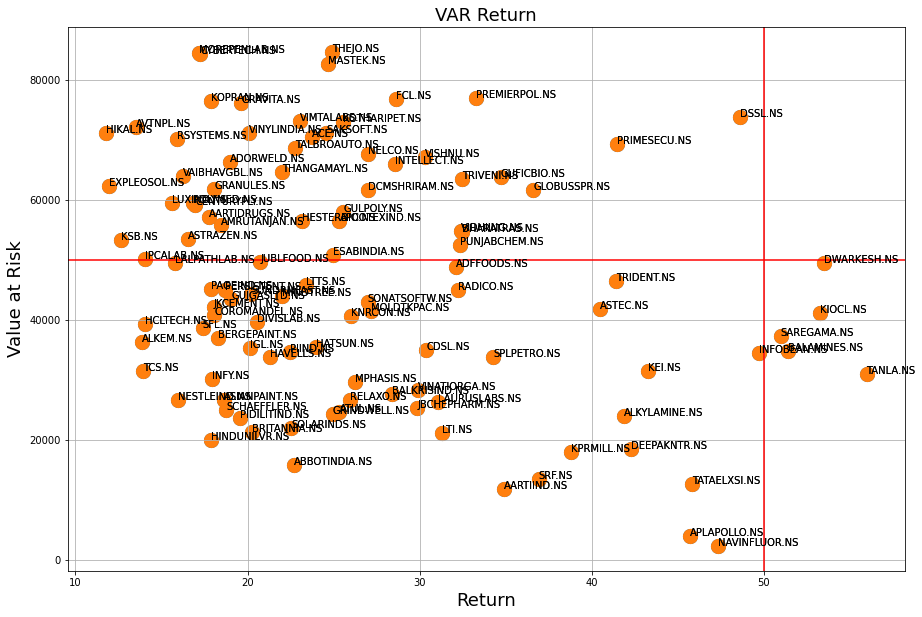

In [28]:
plt.figure(figsize=[15,10])
x= df2['Return%']
y = df2['Value at Risk']
annotations = df2["Ticker"]
plt.grid(True)
plt.title('VAR Return', fontsize=18, color='black')
plt.xlabel("Return",fontsize=18, color='black')
plt.ylabel("Value at Risk", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50000, color='r', linestyle='-')
plt.show()

plt.show()

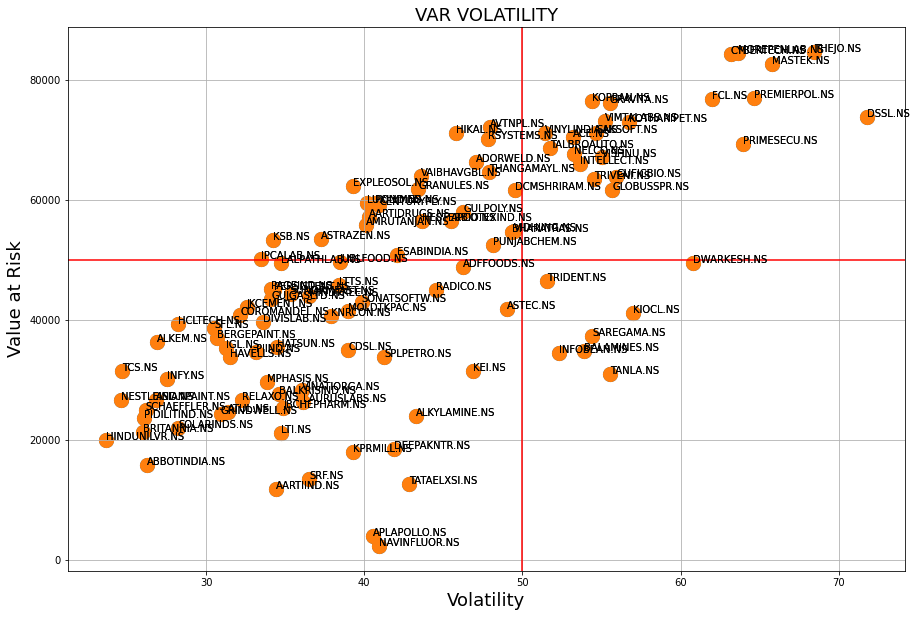

In [29]:
plt.figure(figsize=[15,10])
x= df2['Volatility%']
y = df2['Value at Risk']
annotations = df2["Ticker"]
plt.grid(True)
plt.title('VAR VOLATILITY', fontsize=18, color='black')
plt.xlabel("Volatility",fontsize=18, color='black')
plt.ylabel("Value at Risk", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50000, color='r', linestyle='-')
plt.show()

plt.show()

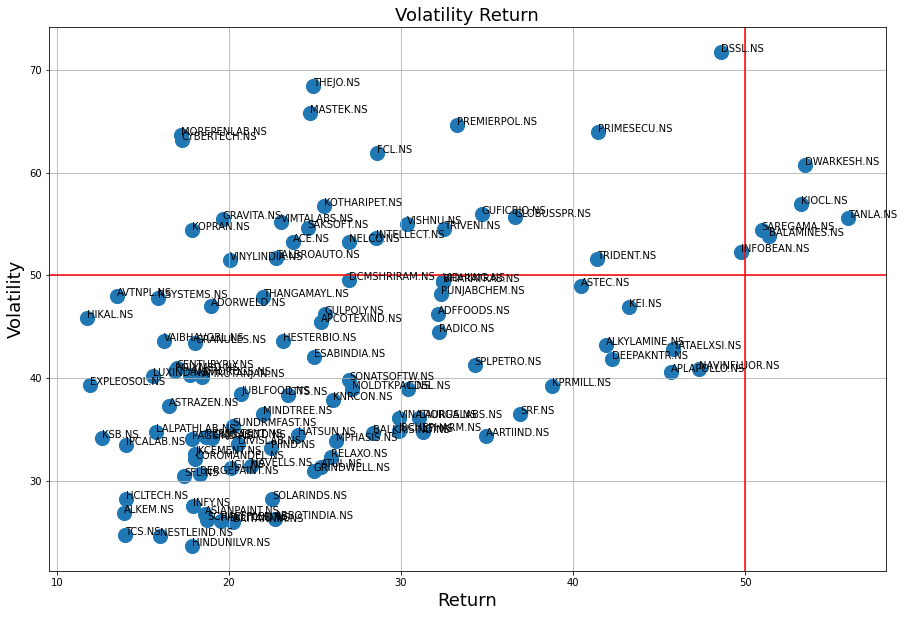

In [30]:
plt.figure(figsize=[15,10])
x= df2['Return%']
y = df2['Volatility%']
annotations = np.array(df2["Ticker"])
plt.grid(True)
plt.title('Volatility Return', fontsize=18, color='black')
plt.xlabel("Return",fontsize=18, color='black')
plt.ylabel("Volatility", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
i=0
for labels in annotations:
    plt.annotate(labels, (x[i], y[i]))
    i=i+1
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50, color='r', linestyle='-')
plt.show()


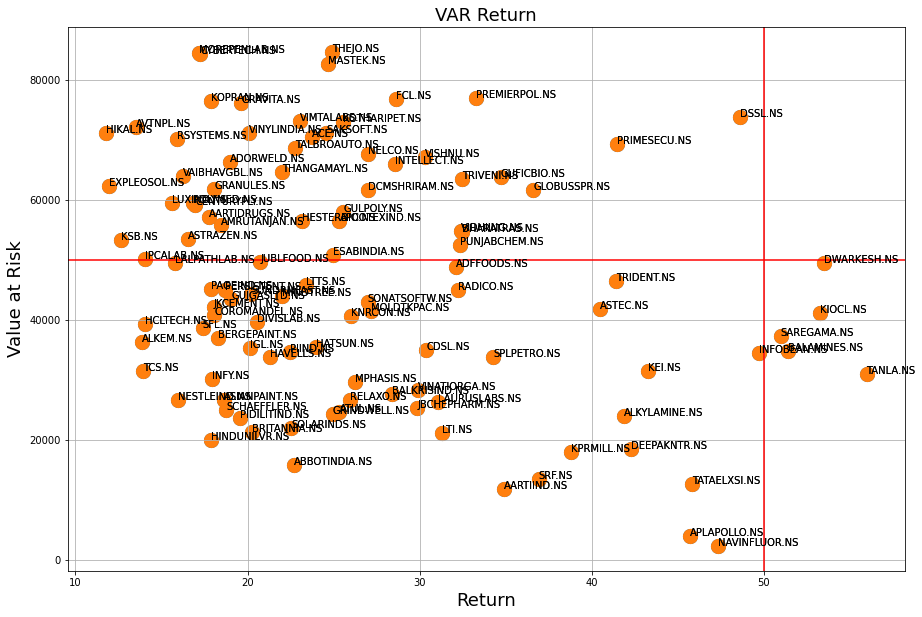

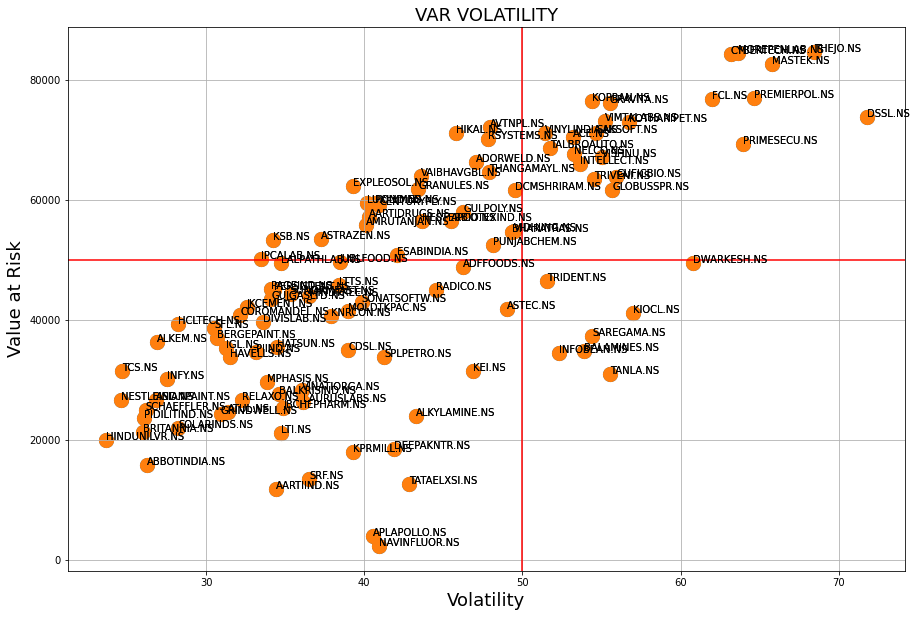

In [31]:
plt.figure(figsize=[15,10])
x= df2['Return%']
y = df2['Value at Risk']
annotations = df2["Ticker"]
plt.grid(True)
plt.title('VAR Return', fontsize=18, color='black')
plt.xlabel("Return",fontsize=18, color='black')
plt.ylabel("Value at Risk", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50000, color='r', linestyle='-')
plt.show()

plt.figure(figsize=[15,10])
x= df2['Volatility%']
y = df2['Value at Risk']
annotations = df2["Ticker"]
plt.grid(True)
plt.title('VAR VOLATILITY', fontsize=18, color='black')
plt.xlabel("Volatility",fontsize=18, color='black')
plt.ylabel("Value at Risk", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50000, color='r', linestyle='-')
plt.show()

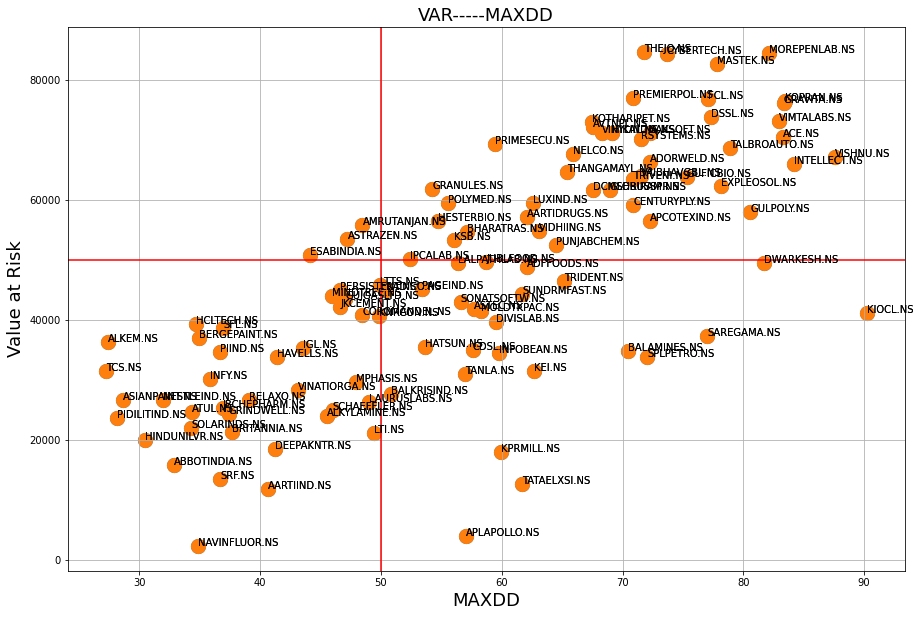

In [32]:

plt.figure(figsize=[15,10])
x= df2['MAXDD%']
y = df2['Value at Risk']
annotations = df2["Ticker"]
plt.grid(True)
plt.title('VAR-----MAXDD', fontsize=18, color='black')
plt.xlabel("MAXDD",fontsize=18, color='black')
plt.ylabel("Value at Risk", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50000, color='r', linestyle='-')
plt.show()

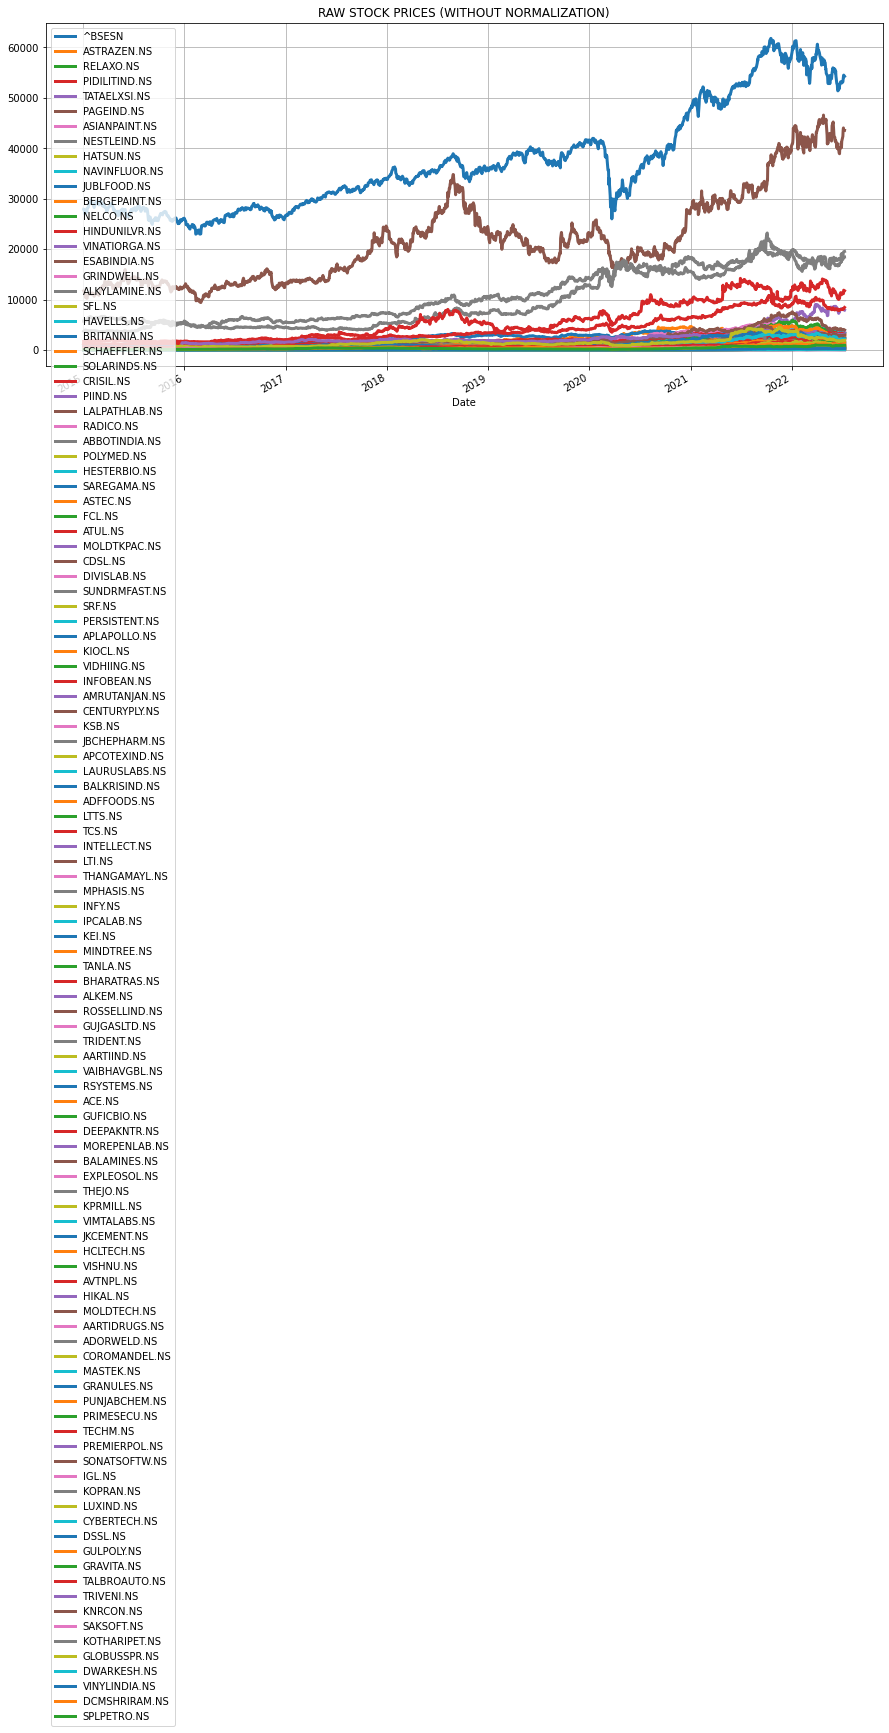

In [33]:
stocks_df = data
def show_plot(df, fig_title):
  df.plot(x = 'Date', figsize = (15,7), linewidth = 3, title = fig_title)
  plt.grid()
  plt.show()
stocks_df = stocks_df.reset_index()
show_plot(stocks_df, 'RAW STOCK PRICES (WITHOUT NORMALIZATION)')

C:\Users\sudhi\.conda\envs\keras\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\sudhi\.conda\envs\keras\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


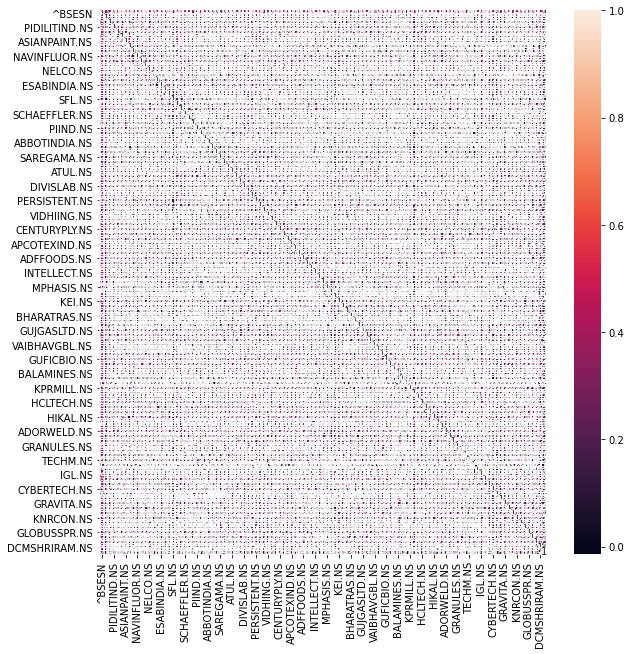

In [34]:
def daily_return(df):
  df_daily_return = df.copy()

  # Loop through each stock (while ignoring time columns with index 0)
  for i in df.columns[1:]:
    
    # Loop through each row belonging to the stock
    for j in range(1, len(df)):

      # Calculate the percentage of change from the previous day
      df_daily_return[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100
    
    # set the value of first row to zero since the previous value is not available
    df_daily_return[i][0] = 0
  
  return df_daily_return

# Get the daily returns 
stocks_daily_return = daily_return(stocks_df)

# Daily Return Correlation
cm = stocks_daily_return.drop(columns = ['Date']).corr()

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from copy import copy
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
plt.figure(figsize=(10, 10))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax);

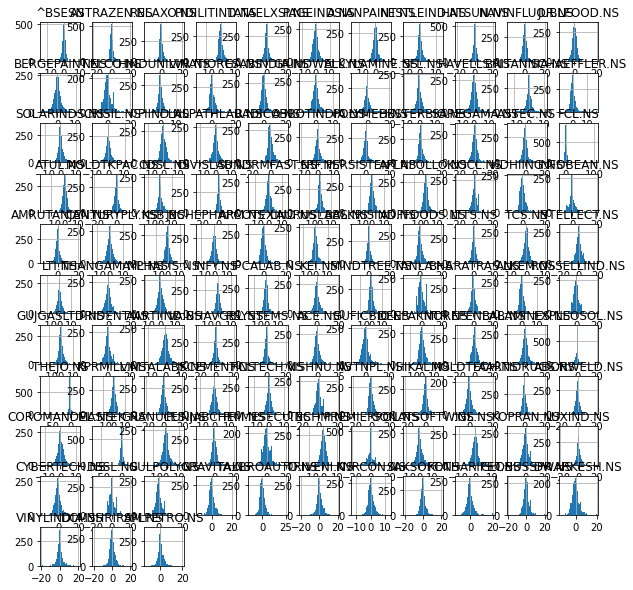

In [35]:
# Histogram of daily returns
# Stock returns are normally distributed with zero mean 
# Notice how Tesla Standard deviation is high indicating a more volatile stock
stocks_daily_return.hist(figsize=(10, 10), bins = 40);

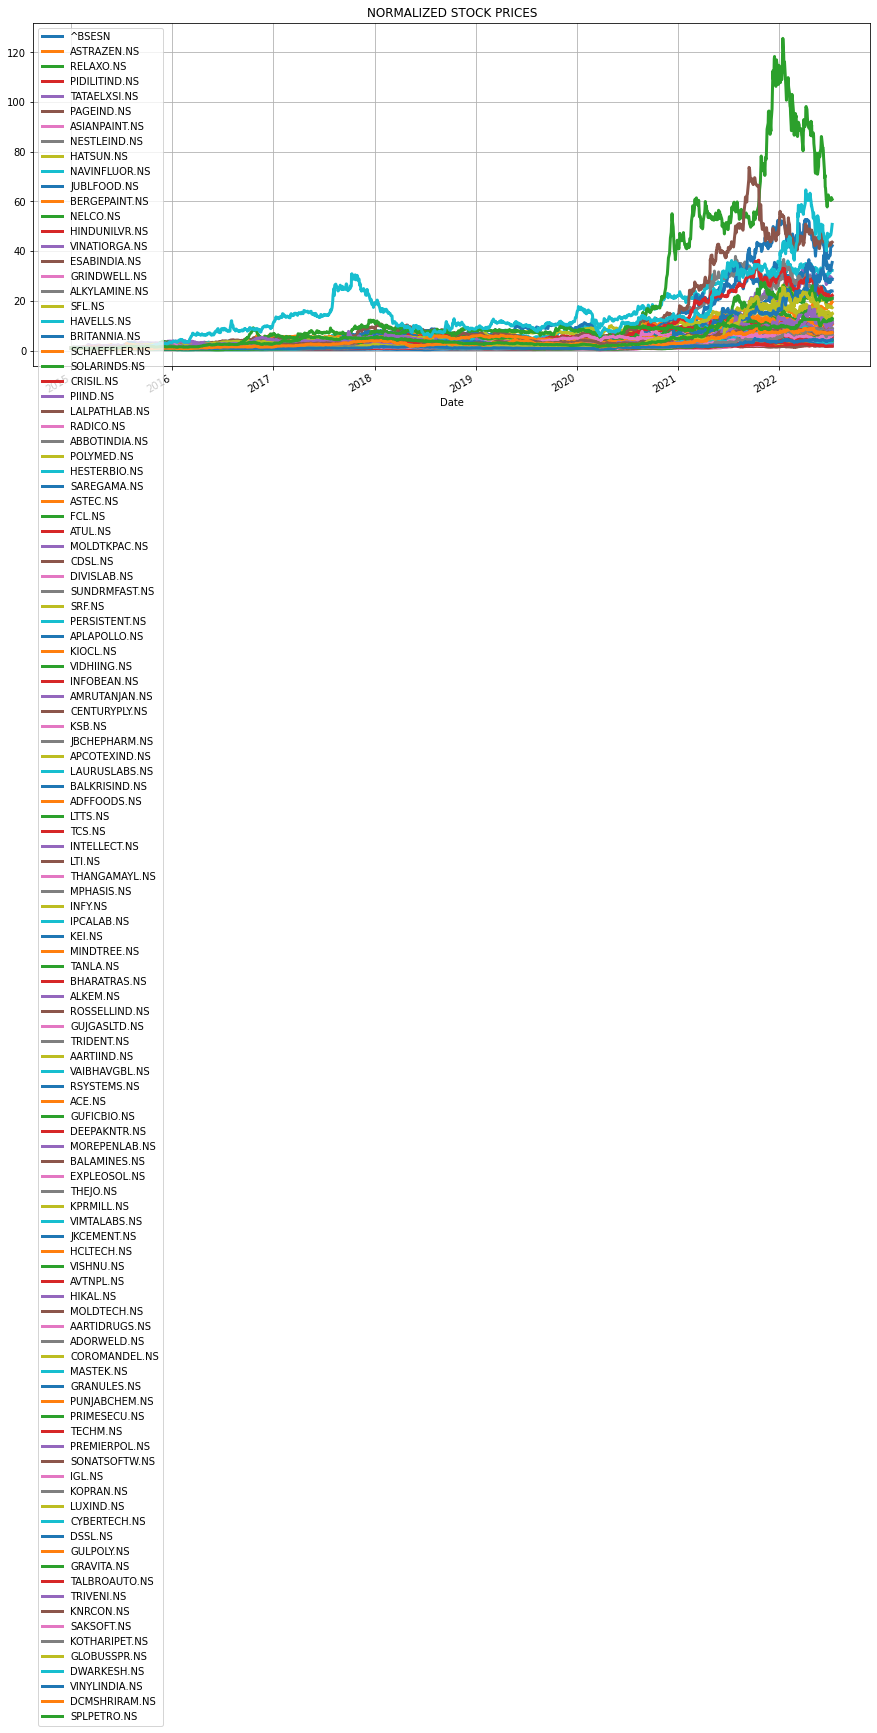

In [36]:
# Function to normalize the prices based on the initial price
# The function simply divides every stock by it's price at the start date (i.e.: Date = 2012-01-12)	
def normalize(df):
  x = df.copy()

  # Loop through each stock (while ignoring time columns with index 0)
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

# Plot normalized data
# Notice the massive gains in Tesla Stock compared to Amazon (second place)
show_plot(normalize(stocks_df), 'NORMALIZED STOCK PRICES')